# 6.2 Black Wednesday: The UK Joining & Leaving the ERM

## 6.2.1 Gather Data [done]

Import everything we need for this notebook. 

In [15]:
import os
import json
import requests
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime

Import the data from previous parts.

In [1]:
# Read the data
s6_monthly_data = pd.read_excel('data/Section6_Monthly_Dataset.xlsx')

def reindex(df):
    df.columns = df.iloc[0]
    df = df.drop(0)  # Drop the first row (since it was the header now)
    
    # Reset index after dropping the row
    df.reset_index(drop=True, inplace=True)
    
    # Name the first 2 columns
    df.columns = [f'Country' if i == 0 
                  else f'Month-Year' if i == 1
                  else col for i, col in enumerate(df.columns)]

    return df

s6_monthly_df = reindex(s6_monthly_data)

s6_monthly_df

,Country,Month-Year,"Economic Activity, Industrial Production, Index","Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate","International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar","Prices, Consumer Price Index, All items, Index"
0,Germany,Jan 1989,74.129549,1.8304,62282.520139,64.969124
1,Germany,Feb 1989,74.762724,1.8521,63127.140877,65.178931
2,Germany,Mar 1989,81.903975,1.8653,62203.567278,65.248867
3,Germany,Apr 1989,79.780034,1.8704,63627.844313,65.66847
4,Germany,May 1989,73.985282,1.9503,62246.09999,65.738406
...,...,...,...,...,...,...
139,United Kingdom,Aug 1994,79.844827,0.648255,45486.461093,72.239689
140,United Kingdom,Sep 1994,87.727301,0.639606,45969.985052,72.350657
141,United Kingdom,Oct 1994,88.747386,0.622748,47211.908673,72.239689
142,United Kingdom,Nov 1994,93.2914,0.629213,46155.254015,72.350657


Separate the two country's data into two dataframes.

In [3]:
# Filter data for UK and Germany
uk_data = s6_monthly_df[s6_monthly_df['Country'] == 'United Kingdom'].copy()
germany_data = s6_monthly_df[s6_monthly_df['Country'] == 'Germany'].copy()

# Convert Month-Year to datetime for better handling
uk_data['Date'] = pd.to_datetime(uk_data['Month-Year'], format='%b %Y')
germany_data['Date'] = pd.to_datetime(germany_data['Month-Year'], format='%b %Y')

# Sort data by date
uk_data = uk_data.sort_values('Date')
germany_data = germany_data.sort_values('Date')

## 6.2.2 Data Preparation [done]

In [4]:
# For better column access, create shorter variable names
uk_data = uk_data.rename(columns={
    'Economic Activity, Industrial Production, Index': 'IP_Index',
    'Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate': 'UK_Ex_Rate_USD',
    'International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar': 'Reserves',
    'Prices, Consumer Price Index, All items, Index': 'CPI'
})

germany_data = germany_data.rename(columns={
    'Economic Activity, Industrial Production, Index': 'IP_Index',
    'Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate': 'Germany_Ex_Rate_USD',
    'International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar': 'Reserves',
    'Prices, Consumer Price Index, All items, Index': 'CPI'
})

In [5]:
# Rename columns for clarity
uk_data = uk_data.rename(columns={
    'ECONOMIC ACTIVITY, INDUSTRIAL PRODUCTION, INDEX': 'IP_Index',
    'Exchange Rates, National Currency Per U.S. Dollar, Period Average, RATE': 'UK_Ex_Rate_USD',
    'INTERNATIONAL RESERVES AND LIQUIDITY, RESERVES, OFFICIAL RESERVE ASSETS, US DOLLAR': 'Reserves',
    'PRICES, CONSUMER PRICE INDEX, ALL ITEMS, INDEX': 'CPI'
})

germany_data = germany_data.rename(columns={
    'ECONOMIC ACTIVITY, INDUSTRIAL PRODUCTION, INDEX': 'IP_Index',
    'Exchange Rates, National Currency Per U.S. Dollar, Period Average, RATE': 'Germany_Ex_Rate_USD',
    'INTERNATIONAL RESERVES AND LIQUIDITY, RESERVES, OFFICIAL RESERVE ASSETS, US DOLLAR': 'Reserves',
    'PRICES, CONSUMER PRICE INDEX, ALL ITEMS, INDEX': 'CPI'
})

# Merge uk_data and germany_data on 'Month-Year'
merged_data = pd.merge(
    uk_data[['Month-Year', 'Date', 'UK_Ex_Rate_USD']],
    germany_data[['Month-Year', 'Germany_Ex_Rate_USD']],
    on='Month-Year',
    how='inner'
)

# Calculate DM/£ exchange rate: If £/$ = a and DM/$ = b, then DM/£ = b/a
merged_data['DM_Pound_Rate'] = merged_data['Germany_Ex_Rate_USD'] / merged_data['UK_Ex_Rate_USD']

merged_data

,Month-Year,Date,UK_Ex_Rate_USD,Germany_Ex_Rate_USD,DM_Pound_Rate
0,Jan 1989,1989-01-01,0.563114,1.8304,3.250496
1,Feb 1989,1989-02-01,0.570181,1.8521,3.248267
2,Mar 1989,1989-03-01,0.583088,1.8653,3.199003
3,Apr 1989,1989-04-01,0.588154,1.8704,3.180119
4,May 1989,1989-05-01,0.613493,1.9503,3.179009
...,...,...,...,...,...
67,Aug 1994,1994-08-01,0.648255,1.5646,2.413555
68,Sep 1994,1994-09-01,0.639606,1.55089,2.424759
69,Oct 1994,1994-10-01,0.622748,1.5184,2.438225
70,Nov 1994,1994-11-01,0.629213,1.53869,2.445418


All important calculations for future use.

In [16]:
# Step 1: Calculate derived columns in uk_data and germany_data

# Calculate monthly inflation rates (percent change in CPI)
uk_data['Inflation'] = uk_data['CPI'].pct_change() * 100
germany_data['Inflation'] = germany_data['CPI'].pct_change() * 100

# Calculate monthly industrial production growth rates
uk_data['IP_Growth'] = uk_data['IP_Index'].pct_change() * 100
germany_data['IP_Growth'] = germany_data['IP_Index'].pct_change() * 100

# Calculate 12-month industrial production growth rates
uk_data['IP_Growth_12m'] = uk_data['IP_Index'].pct_change(periods=12) * 100
germany_data['IP_Growth_12m'] = germany_data['IP_Index'].pct_change(periods=12) * 100

# Step 2: Merge uk_data and germany_data with all relevant columns
merged_data = pd.merge(
    uk_data[[
        'Month-Year', 'Date', 'UK_Ex_Rate_USD', 'Inflation', 'IP_Growth', 'IP_Growth_12m', 'Reserves', 'CPI'
    ]].rename(columns={
        'Inflation': 'UK_Inflation',
        'IP_Growth': 'UK_IP_Growth',
        'IP_Growth_12m': 'UK_IP_Growth_12m',
        'Reserves': 'UK_Reserves'
    }),
    germany_data[[
        'Month-Year', 'Germany_Ex_Rate_USD', 'Inflation', 'IP_Growth', 'IP_Growth_12m', 'Reserves', 'CPI'
    ]].rename(columns={
        'Inflation': 'Germany_Inflation',
        'IP_Growth': 'Germany_IP_Growth',
        'IP_Growth_12m': 'Germany_IP_Growth_12m',
        'Reserves': 'Germany_Reserves'
    }),
    on='Month-Year',
    how='inner'
)

# Step 3: Calculate additional columns in merged_data

# Calculate DM/£ nominal exchange rate
merged_data['DM_Pound_Rate'] = merged_data['Germany_Ex_Rate_USD'] / merged_data['UK_Ex_Rate_USD']

# Calculate inflation differential (UK minus Germany)
merged_data['Inflation_Differential'] = merged_data['UK_Inflation'] - merged_data['Germany_Inflation']

# Calculate real exchange rate (DM/£)
# Real Exchange Rate = Nominal Exchange Rate * (Foreign Price Level / Domestic Price Level)
merged_data['Real_DM_Pound_Rate'] = merged_data['DM_Pound_Rate'] * (merged_data['CPI_y'] / merged_data['CPI_x'])

# Calculate monthly real exchange rate growth
merged_data['Real_Exchange_Rate_Growth'] = merged_data['Real_DM_Pound_Rate'].pct_change() * 100

/tmp/ipykernel_14489/447423461.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data['Real_Exchange_Rate_Growth'] = merged_data['Real_DM_Pound_Rate'].pct_change() * 100


Check that everything is ok.

In [17]:
merged_data

,Month-Year,Date,UK_Ex_Rate_USD,UK_Inflation,UK_IP_Growth,UK_IP_Growth_12m,UK_Reserves,CPI_x,Germany_Ex_Rate_USD,Germany_Inflation,Germany_IP_Growth,Germany_IP_Growth_12m,Germany_Reserves,CPI_y,DM_Pound_Rate,Inflation_Differential,Real_DM_Pound_Rate,Real_Exchange_Rate_Growth
0,Jan 1989,1989-01-01,0.563114,NaN,NaN,NaN,49490.842899,54.928796,1.8304,NaN,NaN,NaN,62282.520139,64.969124,3.250496,NaN,3.844648,NaN
1,Feb 1989,1989-02-01,0.570181,0.404040,0.691244,NaN,49914.121049,55.150731,1.8521,0.322934,0.854146,NaN,63127.140877,65.178931,3.248267,0.081107,3.838908,-0.149316
2,Mar 1989,1989-03-01,0.583088,0.603622,9.496568,NaN,46872.450858,55.483632,1.8653,0.107298,9.551887,NaN,62203.567278,65.248867,3.199003,0.496324,3.762034,-2.002495
3,Apr 1989,1989-04-01,0.588154,1.000000,-9.822362,NaN,47374.705938,56.038469,1.8704,0.643081,-2.593209,NaN,63627.844313,65.668470,3.180119,0.356919,3.726611,-0.941578
4,May 1989,1989-05-01,0.613493,0.792079,0.811124,NaN,45042.107822,56.482338,1.9503,0.106498,-7.263412,NaN,62246.09999,65.738406,3.179009,0.685581,3.699971,-0.714864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Aug 1994,1994-08-01,0.648255,0.618238,1.652893,9.681529,45486.461093,72.239689,1.5646,0.251893,-0.725689,4.109589,92921.151347,79.606631,2.413555,0.366345,2.659687,-0.918030
68,Sep 1994,1994-09-01,0.639606,0.153610,9.872242,6.292135,45969.985052,72.350657,1.55089,-0.251260,16.959064,3.225806,93841.679875,79.406611,2.424759,0.404870,2.661232,0.058074
69,Oct 1994,1994-10-01,0.622748,-0.153374,1.162791,5.629139,47211.908673,72.239689,1.5184,-0.125947,-3.375000,1.576873,94125.910097,79.306601,2.438225,-0.027428,2.676747,0.582997
70,Nov 1994,1994-11-01,0.629213,0.153610,5.120167,4.248705,46155.254015,72.350657,1.53869,0.126105,4.657180,5.064935,91460.327632,79.406611,2.445418,0.027504,2.683906,0.267469


## 6.2.3 Analysis: UK Joining ERM [done]

### In this section, we will answer the question: "What was a key reason for why the UK chose to join the ERM and fix their exchange rate?" 

In [7]:
# Define key dates
erm_join_date = pd.to_datetime('1990-10-08')  # UK joined ERM
black_wednesday = pd.to_datetime('1992-09-16')  # Black Wednesday

According to [ig.com](https://www.ig.com/uk/trading-strategies/black-wednesday-explained-230712#:~:text=This%20was%20in%20the%20hope,Exchange%20Rate%20Mechanism%20(ERM).), UK joined the ERM "in the hope that the UK could align itself with Germany's considerably lower level of inflation".

Thus, we will first plot a graph that shows Inflation Rates of both UK nd Germany before UK joined ERM to see if this is true.

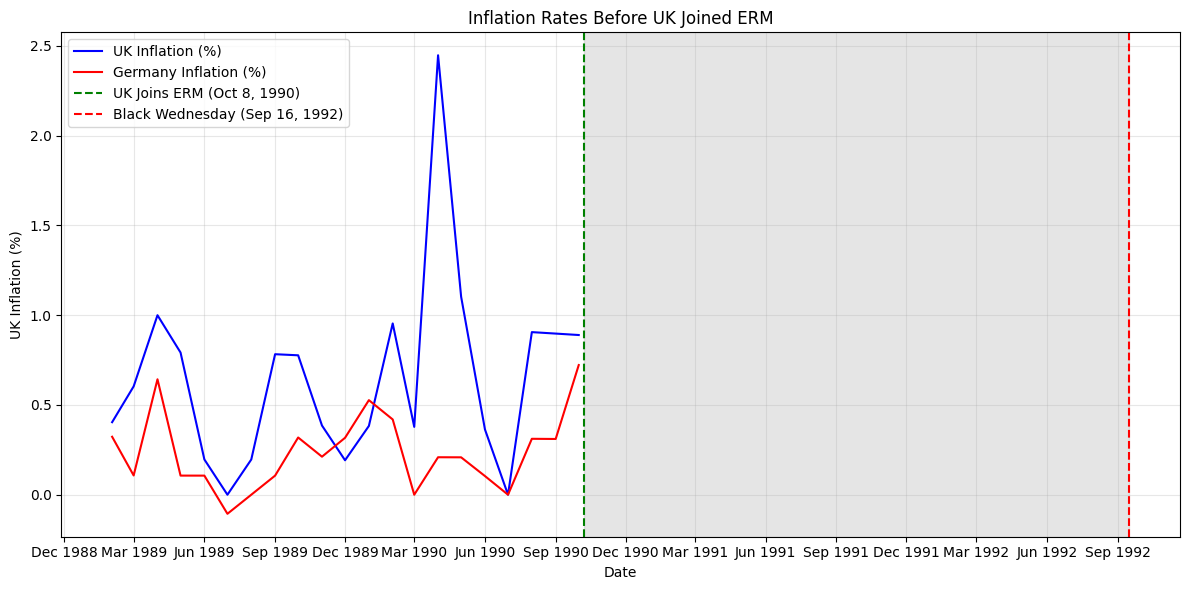

In [8]:
def plt_with_erm_period(x, y, title, ylabel, figsize=(12, 6), y2=None, y2label=None):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x, y, label=ylabel, color='blue')
    if y2 is not None:
        ax.plot(x, y2, label=y2label, color='red')
    ax.axvspan(erm_join_date, black_wednesday, alpha=0.2, color='gray')
    ax.axvline(x=erm_join_date, color='green', linestyle='--', label='UK Joins ERM (Oct 8, 1990)')
    ax.axvline(x=black_wednesday, color='red', linestyle='--', label='Black Wednesday (Sep 16, 1992)')
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig, ax

# Plot inflation rates for UK and Germany before joining ERM
pre_erm_data = merged_data[merged_data['Date'] < erm_join_date].copy()

fig, ax = plt_with_erm_period(
    pre_erm_data['Date'],
    pre_erm_data['UK_Inflation'],
    'Inflation Rates Before UK Joined ERM',
    'UK Inflation (%)',
    y2=pre_erm_data['Germany_Inflation'],
    y2label='Germany Inflation (%)'
)

plt.show()

As we can see clearly from the graph, the blue line illustrating UK's inflation was consistently higher than Germany's Inflation, in all months other than around the new year's of 1990, even spiking to a high ~2.4% when Germany's Inflation was only around 0.2%, a huge disparity.

### Therefore, a key reason for why the UK chose to join the ERM was to control their (higher than Germany) inflation. This is consistent with many sources mentioning that this is the "birth of inflation targetting". 

Now we will explore data on UK's exchange rate.

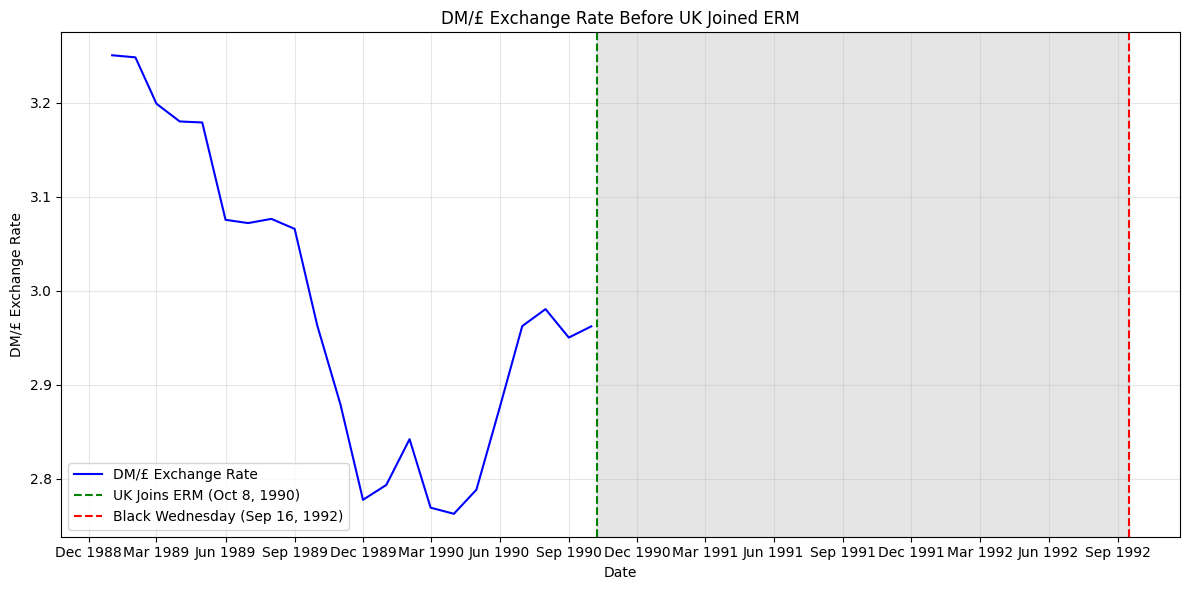

In [9]:
# Plot exchange rate movements leading up to joining
pre_erm_data = merged_data[merged_data['Date'] < erm_join_date].copy()

# Drop rows with NaN values in DM_Pound_Rate to ensure the plot is complete
pre_erm_data = pre_erm_data.dropna(subset=['DM_Pound_Rate'])

# Plot the data
fig, ax = plt_with_erm_period(
    pre_erm_data['Date'], 
    pre_erm_data['DM_Pound_Rate'], 
    'DM/£ Exchange Rate Before UK Joined ERM', 
    'DM/£ Exchange Rate'
)

plt.show()

One of the main objectives of the ERM was "to maintain the currency values relative to each other", according to [The Guardian](https://www.theguardian.com/business/2012/sep/13/black-wednesday-20-years-pound-erm). We can see that UK's Exchange rate was relatively unstable compared to the more stable DM rate. 

### Thus, UK's unstable exchange rate may be another reason the UK wanted to join ERM.

## 6.2.4 Analysis: Currency Attack

In [10]:
# Filter data for the period around the currency attack (3 months before and after)
attack_period_start = pd.to_datetime('1992-06-16')
attack_period_end = pd.to_datetime('1992-12-16')
attack_period_data = merged_data[(merged_data['Date'] >= attack_period_start) & 
                                (merged_data['Date'] <= attack_period_end)].copy()

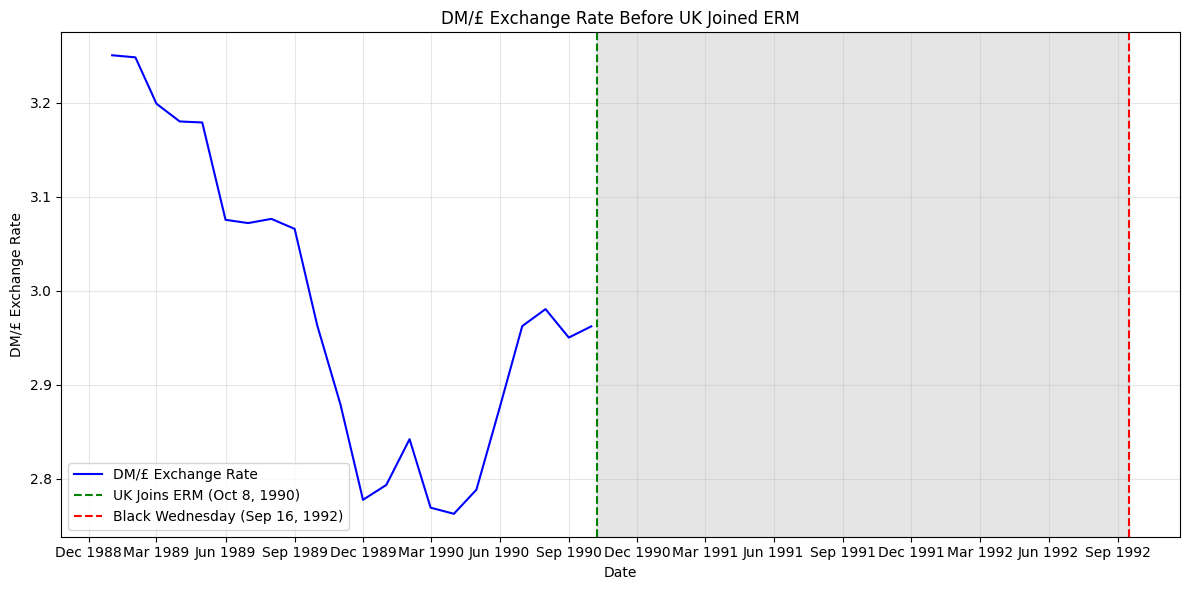

In [11]:
# Plot exchange rate movements leading up to joining
pre_erm_data = merged_data[merged_data['Date'] < erm_join_date].copy()
pre_erm_data = pre_erm_data.dropna(subset=['DM_Pound_Rate'])

fig, ax = plt_with_erm_period(
    pre_erm_data['Date'], 
    pre_erm_data['DM_Pound_Rate'], 
    'DM/£ Exchange Rate Before UK Joined ERM', 
    'DM/£ Exchange Rate'
)

plt.show()

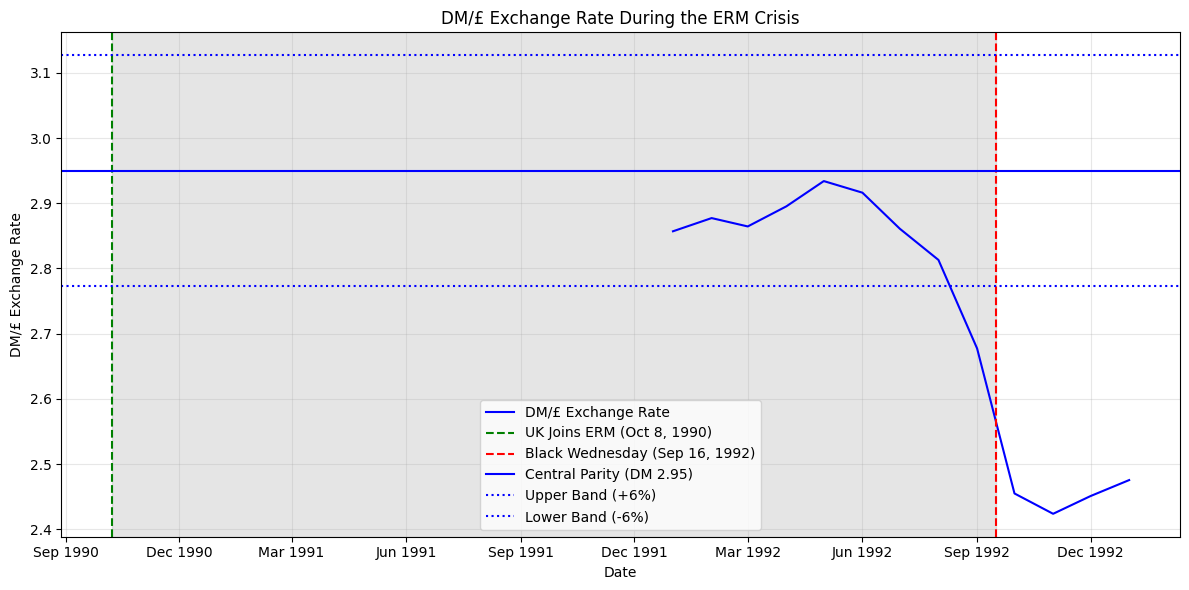

In [12]:
crisis_period_data = merged_data[(merged_data['Date'] >= pd.to_datetime('1992-01-01')) & 
                                (merged_data['Date'] <= pd.to_datetime('1993-01-01'))].copy()

# Plot DM/£ exchange rate during the crisis period
fig, ax = plt_with_erm_period(
    crisis_period_data['Date'], 
    crisis_period_data['DM_Pound_Rate'], 
    'DM/£ Exchange Rate During the ERM Crisis', 
    'DM/£ Exchange Rate'
)
# Add horizontal line for the central parity rate
ax.axhline(y=2.95, color='blue', linestyle='-', label='Central Parity (DM 2.95)')
# Add horizontal lines for the permitted fluctuation band (6%)
ax.axhline(y=2.95 * 1.06, color='blue', linestyle=':', label='Upper Band (+6%)')
ax.axhline(y=2.95 * 0.94, color='blue', linestyle=':', label='Lower Band (-6%)')
ax.legend()
plt.show()

- Create graph showing UK's international reserves before and during attack
- Create graph showing DM/£ exchange rate during the crisis period
- Analyze what factors led to the speculative attack
- Write explanation of Soros's currency attack (supported by your data)

## 6.2.5 Volatility Analysis

/tmp/ipykernel_14489/288232495.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data['Real_Exchange_Rate_Growth'] = merged_data['Real_DM_Pound_Rate'].pct_change() * 100


Standard Deviations Across ERM Periods (1989-1995):
       Period  Real Exchange Rate Growth  Inflation Differential  \
0     Pre-ERM                   1.927244                0.503479   
1  During-ERM                   1.493427                0.692328   
2    Post-ERM                   2.570911                0.563666   

   UK Industrial Production Growth  Germany Industrial Production Growth  
0                         7.080000                              7.034312  
1                         7.073991                              8.133574  
2                         7.204278                              9.257024  

Number of Data Points in Each Period:
Pre-ERM: 22
During-ERM: 23
Post-ERM: 27


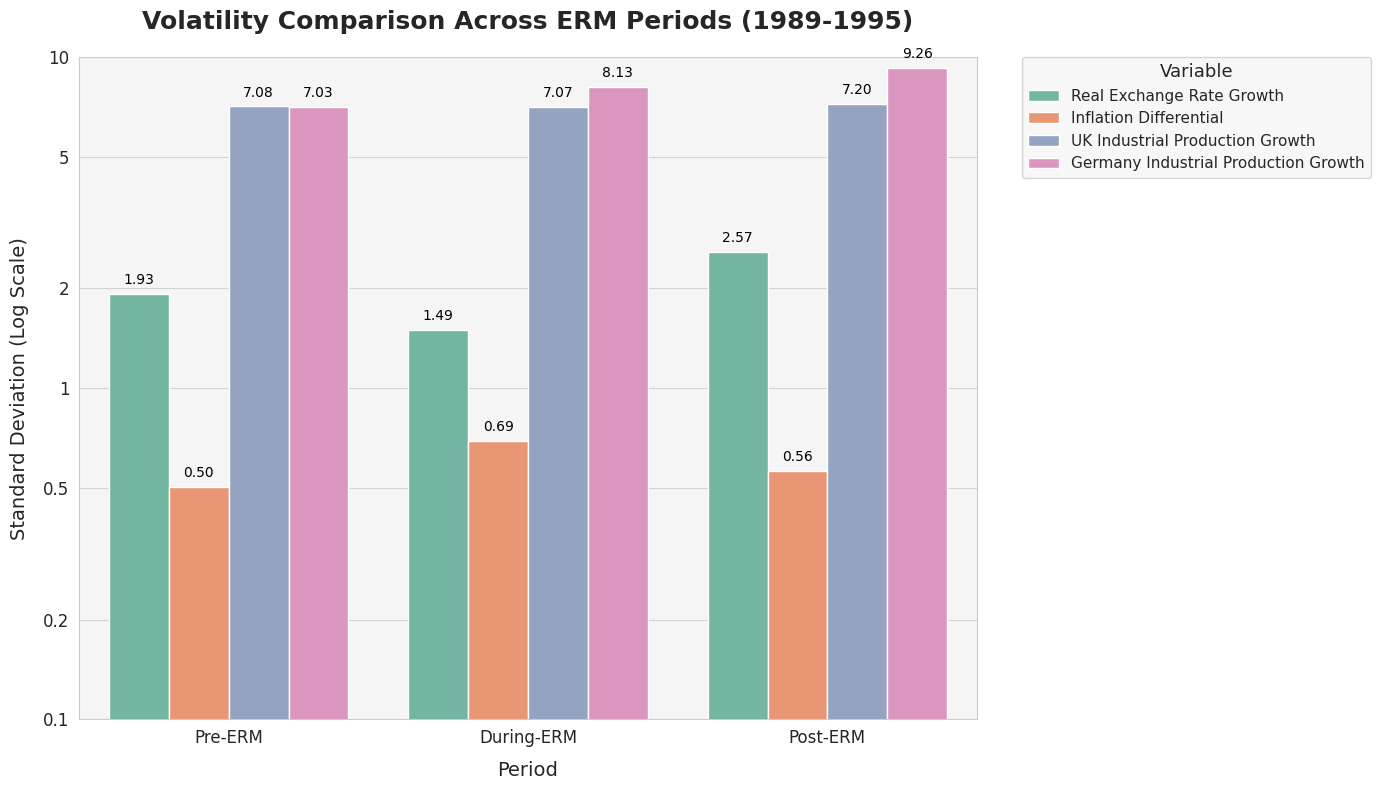

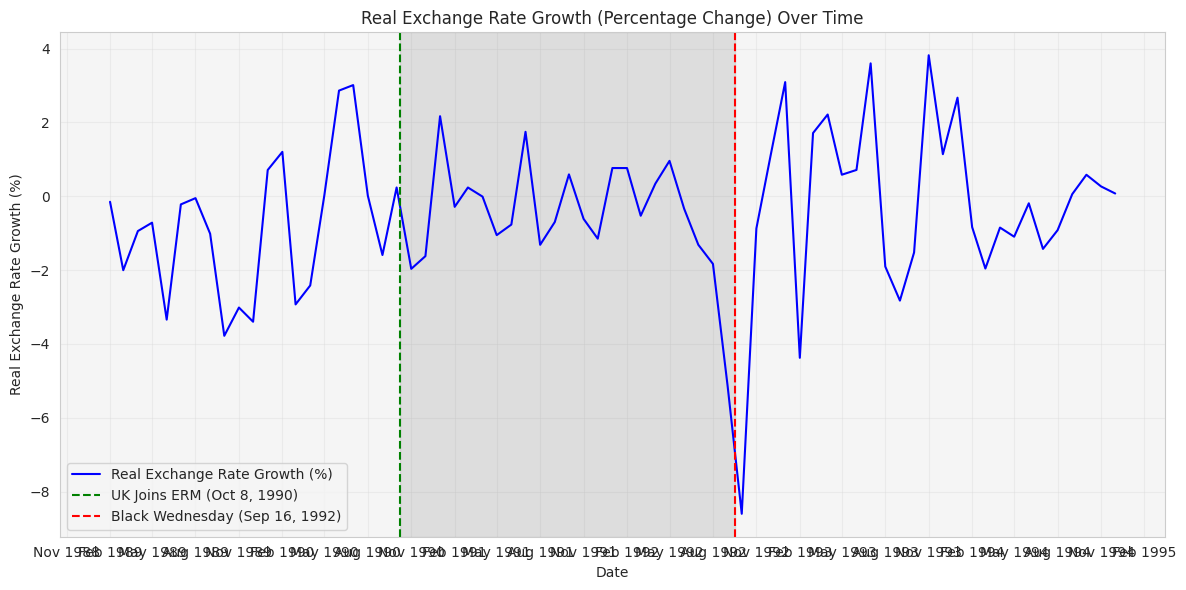

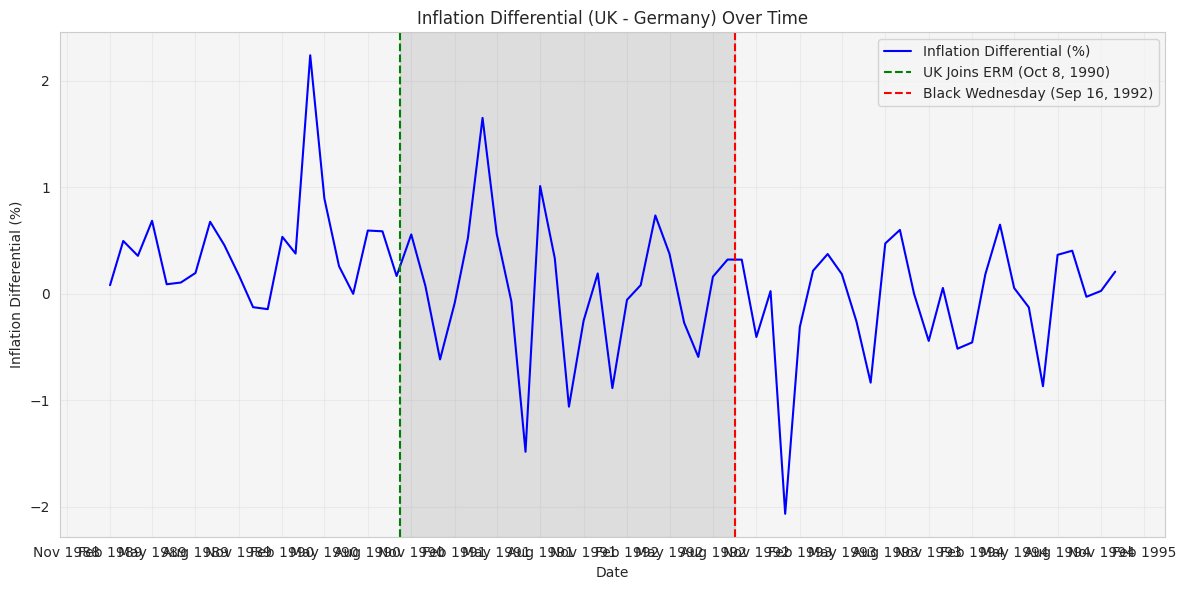

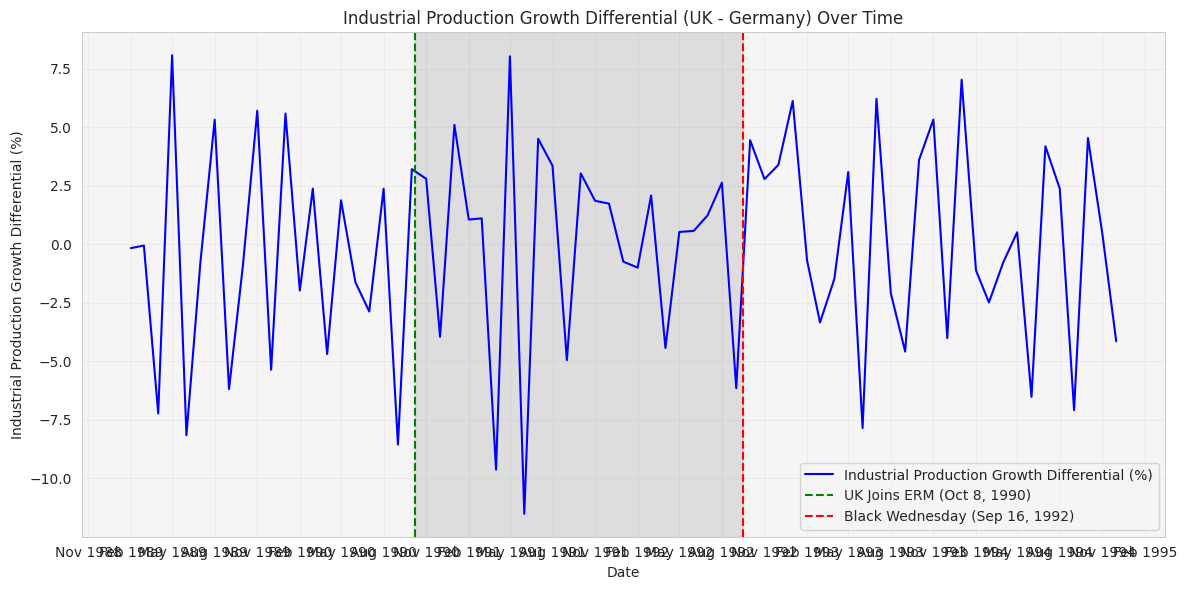

In [13]:
# Step 1: Calculate derived columns in uk_data and germany_data
uk_data['CPI'] = pd.to_numeric(uk_data['CPI'], errors='coerce')
germany_data['CPI'] = pd.to_numeric(germany_data['CPI'], errors='coerce')
uk_data['IP_Index'] = pd.to_numeric(uk_data['IP_Index'], errors='coerce')
germany_data['IP_Index'] = pd.to_numeric(germany_data['IP_Index'], errors='coerce')

uk_data['Inflation'] = uk_data['CPI'].pct_change() * 100
germany_data['Inflation'] = germany_data['CPI'].pct_change() * 100

uk_data['IP_Growth'] = uk_data['IP_Index'].pct_change() * 100
germany_data['IP_Growth'] = germany_data['IP_Index'].pct_change() * 100

uk_data['IP_Growth_12m'] = uk_data['IP_Index'].pct_change(periods=12) * 100
germany_data['IP_Growth_12m'] = germany_data['IP_Index'].pct_change(periods=12) * 100

# Step 2: Merge uk_data and germany_data with all relevant columns
merged_data = pd.merge(
    uk_data[[
        'Month-Year', 'Date', 'UK_Ex_Rate_USD', 'Inflation', 'IP_Growth', 'IP_Growth_12m', 'Reserves', 'CPI'
    ]].rename(columns={
        'Inflation': 'UK_Inflation',
        'IP_Growth': 'UK_IP_Growth',
        'IP_Growth_12m': 'UK_IP_Growth_12m',
        'Reserves': 'UK_Reserves'
    }),
    germany_data[[
        'Month-Year', 'Germany_Ex_Rate_USD', 'Inflation', 'IP_Growth', 'IP_Growth_12m', 'Reserves', 'CPI'
    ]].rename(columns={
        'Inflation': 'Germany_Inflation',
        'IP_Growth': 'Germany_IP_Growth',
        'IP_Growth_12m': 'Germany_IP_Growth_12m',
        'Reserves': 'Germany_Reserves'
    }),
    on='Month-Year',
    how='inner'
)

# Step 3: Calculate additional columns in merged_data
merged_data['DM_Pound_Rate'] = merged_data['Germany_Ex_Rate_USD'] / merged_data['UK_Ex_Rate_USD']
merged_data['Inflation_Differential'] = merged_data['UK_Inflation'] - merged_data['Germany_Inflation']
merged_data['Real_DM_Pound_Rate'] = merged_data['DM_Pound_Rate'] * (merged_data['CPI_y'] / merged_data['CPI_x'])
merged_data['Real_Exchange_Rate_Growth'] = merged_data['Real_DM_Pound_Rate'].pct_change() * 100
merged_data['IP_Growth_Difference'] = merged_data['UK_IP_Growth'] - merged_data['Germany_IP_Growth']

# Volatility Analysis (using full time range, all three periods)
pre_erm = merged_data[merged_data['Date'] < erm_join_date].copy()
during_erm = merged_data[(merged_data['Date'] >= erm_join_date) & (merged_data['Date'] <= black_wednesday)].copy()
post_erm = merged_data[merged_data['Date'] > black_wednesday].copy()

# Calculate standard deviation of real exchange rate growth for each period
sd_pre_erm_rex = pre_erm['Real_Exchange_Rate_Growth'].std()
sd_during_erm_rex = during_erm['Real_Exchange_Rate_Growth'].std()
sd_post_erm_rex = post_erm['Real_Exchange_Rate_Growth'].std()

# Calculate standard deviation of inflation differential for each period
sd_pre_erm_inf = pre_erm['Inflation_Differential'].std()
sd_during_erm_inf = during_erm['Inflation_Differential'].std()
sd_post_erm_inf = post_erm['Inflation_Differential'].std()

# Calculate standard deviation of industrial production growth for each period (UK and Germany)
sd_pre_erm_ip_uk = pre_erm['UK_IP_Growth'].std()
sd_during_erm_ip_uk = during_erm['UK_IP_Growth'].std()
sd_post_erm_ip_uk = post_erm['UK_IP_Growth'].std()

sd_pre_erm_ip = pre_erm['Germany_IP_Growth'].std()
sd_during_erm_ip = during_erm['Germany_IP_Growth'].std()
sd_post_erm_ip = post_erm['Germany_IP_Growth'].std()

# Create a DataFrame for the standard deviations
sd_df = pd.DataFrame({
    'Period': ['Pre-ERM', 'During-ERM', 'Post-ERM'],
    'Real Exchange Rate Growth': [sd_pre_erm_rex, sd_during_erm_rex, sd_post_erm_rex],
    'Inflation Differential': [sd_pre_erm_inf, sd_during_erm_inf, sd_post_erm_inf],
    'UK Industrial Production Growth': [sd_pre_erm_ip_uk, sd_during_erm_ip_uk, sd_post_erm_ip_uk],
    'Germany Industrial Production Growth': [sd_pre_erm_ip, sd_during_erm_ip, sd_post_erm_ip]
})

# Print the standard deviations and number of data points
print("Standard Deviations Across ERM Periods (1989-1995):")
print(sd_df)
print("\nNumber of Data Points in Each Period:")
print("Pre-ERM:", len(pre_erm))
print("During-ERM:", len(during_erm))
print("Post-ERM:", len(post_erm))

# Melt the DataFrame for plotting
sd_df_melted = pd.melt(sd_df, id_vars=['Period'], var_name='Variable', value_name='Standard Deviation')

# Set a modern seaborn style
sns.set_style("whitegrid", {"axes.facecolor": "#f5f5f5", "grid.color": "#d3d3d3"})

# Create the bar chart
plt.figure(figsize=(14, 8))
custom_palette = sns.color_palette("Set2", n_colors=len(sd_df_melted['Variable'].unique()))
chart = sns.barplot(x='Period', y='Standard Deviation', hue='Variable', data=sd_df_melted, palette=custom_palette)

# Use a logarithmic scale for the y-axis with more ticks
plt.yscale('log')
plt.ylim(0.1, 10)
plt.yticks([0.1, 0.2, 0.5, 1, 2, 5, 10], ['0.1', '0.2', '0.5', '1', '2', '5', '10'], fontsize=12)

# Add title and labels
plt.title('Volatility Comparison Across ERM Periods (1989-1995)', fontsize=18, pad=20, fontweight='bold')
plt.xlabel('Period', fontsize=14, labelpad=10)
plt.ylabel('Standard Deviation (Log Scale)', fontsize=14, labelpad=10)

# Rotate x-axis labels
plt.xticks(rotation=0, fontsize=12)

# Customize the legend
plt.legend(title='Variable', title_fontsize='13', fontsize='11', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Add annotations on top of each bar
for p in chart.patches:
    height = p.get_height()
    if height > 0:
        chart.annotate(f'{height:.2f}', 
                       (p.get_x() + p.get_width() / 2., height), 
                       ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), 
                       textcoords='offset points')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Time-series plots for the full time period (1989-1995)
fig, ax = plt_with_erm_period(
    merged_data['Date'],
    merged_data['Real_Exchange_Rate_Growth'],
    'Real Exchange Rate Growth (Percentage Change) Over Time',
    'Real Exchange Rate Growth (%)'
)
plt.show()

fig, ax = plt_with_erm_period(
    merged_data['Date'],
    merged_data['Inflation_Differential'],
    'Inflation Differential (UK - Germany) Over Time',
    'Inflation Differential (%)'
)
plt.show()

fig, ax = plt_with_erm_period(
    merged_data['Date'],
    merged_data['IP_Growth_Difference'],
    'Industrial Production Growth Differential (UK - Germany) Over Time',
    'Industrial Production Growth Differential (%)'
)
plt.show()

- Define three periods: pre-ERM, during-ERM, post-ERM
- Calculate standard deviation of real exchange rate growth for each period
- Calculate standard deviation of inflation differential for each period
- Calculate standard deviation of industrial production growth for each period
- Create comparative chart showing volatility changes across periods
- Write analysis of how volatility changed after joining/leaving ERM

## 6.2.6 Level Analysis

In [14]:
# Define the periods
pre_erm = merged_data[merged_data['Date'] < erm_join_date].copy()
during_erm = merged_data[(merged_data['Date'] >= erm_join_date) & (merged_data['Date'] <= black_wednesday)].copy()
post_erm = merged_data[merged_data['Date'] > black_wednesday].copy()

# Calculate average values for each period
avg_pre_erm = pre_erm['DM_Pound_Rate'].mean()
avg_during_erm = during_erm['DM_Pound_Rate'].mean()
avg_post_erm = post_erm['DM_Pound_Rate'].mean()

avg_pre_erm_inf = pre_erm['Inflation_Differential'].mean()
avg_during_erm_inf = during_erm['Inflation_Differential'].mean()
avg_post_erm_inf = post_erm['Inflation_Differential'].mean()

# Calculate the difference in 12-month industrial production growth
merged_data['IP_Growth_12m_Difference'] = merged_data['UK_IP_Growth_12m'] - merged_data['Germany_IP_Growth_12m']

# Calculate averages for the difference in 12-month industrial production growth
avg_pre_erm_ip_diff = pre_erm['IP_Growth_12m_Difference'].mean()
avg_during_erm_ip_diff = during_erm['IP_Growth_12m_Difference'].mean()
avg_post_erm_ip_diff = post_erm['IP_Growth_12m_Difference'].mean()

# Calculate the percentage change in DM_Pound_Rate around Black Wednesday
before_bw = merged_data[merged_data['Date'] <= black_wednesday].iloc[-1]
after_bw = merged_data[merged_data['Date'] > black_wednesday].iloc[0]
pct_change_bw = ((after_bw['DM_Pound_Rate'] - before_bw['DM_Pound_Rate']) / before_bw['DM_Pound_Rate']) * 100

# Print the numerical analysis
print("DM/£ Exchange Rate Analysis:")
print(f"Average Pre-ERM: {avg_pre_erm:.2f}")
print(f"Average During-ERM: {avg_during_erm:.2f}")
print(f"Average Post-ERM: {avg_post_erm:.2f}")
print(f"Percentage Change at Black Wednesday: {pct_change_bw:.2f}%")
print("\nInflation Differential Analysis (UK - Germany):")
print(f"Average Pre-ERM: {avg_pre_erm_inf:.2f}%")
print(f"Average During-ERM: {avg_during_erm_inf:.2f}%")
print(f"Average Post-ERM: {avg_post_erm_inf:.2f}%")
print("\n12-Month Industrial Production Growth Differential Analysis (UK - Germany):")
print(f"Average Pre-ERM: {avg_pre_erm_ip_diff:.2f}%")
print(f"Average During-ERM: {avg_during_erm_ip_diff:.2f}%")
print(f"Average Post-ERM: {avg_post_erm_ip_diff:.2f}%")

# Plot time-series for all variables
plt.figure(figsize=(14, 12))

# DM/£ Exchange Rate (1989-1995)
plt.subplot(3, 1, 1)
plt.plot(merged_data['Date'], merged_data['DM_Pound_Rate'], label='DM/£ Exchange Rate', color='blue')
plt.axvline(erm_join_date, color='green', linestyle='--', label='UK Joins ERM')
plt.axvline(black_wednesday, color='red', linestyle='--', label='Black Wednesday')
plt.axhline(avg_pre_erm, xmin=0, xmax=(erm_join_date - merged_data['Date'].min()).days / (merged_data['Date'].max() - merged_data['Date'].min()).days, color='blue', alpha=0.3, linestyle='--', label=f'Pre-ERM Avg: {avg_pre_erm:.2f}')
plt.axhline(avg_during_erm, xmin=(erm_join_date - merged_data['Date'].min()).days / (merged_data['Date'].max() - merged_data['Date'].min()).days, xmax=(black_wednesday - merged_data['Date'].min()).days / (merged_data['Date'].max() - merged_data['Date'].min()).days, color='green', alpha=0.3, linestyle='--', label=f'During-ERM Avg: {avg_during_erm:.2f}')
plt.axhline(avg_post_erm, xmin=(black_wednesday - merged_data['Date'].min()).days / (merged_data['Date'].max() - merged_data['Date'].min()).days, xmax=1, color='red', alpha=0.3, linestyle='--', label=f'Post-ERM Avg: {avg_post_erm:.2f}')
plt.annotate(f'Change: {pct_change_bw:.2f}%', xy=(black_wednesday, after_bw['DM_Pound_Rate']), xytext=(black_wednesday, after_bw['DM_Pound_Rate'] + 0.2), arrowprops=dict(facecolor='black', shrink=0.05))
plt.title('DM/£ Exchange Rate (1989-1995)')
plt.ylabel('DM/£ Exchange Rate')
plt.legend()

# UK-Germany Inflation Differential (1989-1995)
plt.subplot(3, 1, 2)
plt.plot(merged_data['Date'], merged_data['Inflation_Differential'], color='green', linestyle='-', label='UK-Germany Inflation Differential')
plt.axvline(erm_join_date, color='green', linestyle='--', label='UK Joins ERM')
plt.axvline(black_wednesday, color='red', linestyle='--', label='Black Wednesday')
plt.axhline(avg_pre_erm_inf, xmin=0, xmax=(erm_join_date - merged_data['Date'].min()).days / (merged_data['Date'].max() - merged_data['Date'].min()).days, color='blue', alpha=0.3, linestyle='--', label=f'Pre-ERM Avg: {avg_pre_erm_inf:.2f}%')
plt.axhline(avg_during_erm_inf, xmin=(erm_join_date - merged_data['Date'].min()).days / (merged_data['Date'].max() - merged_data['Date'].min()).days, xmax=(black_wednesday - merged_data['Date'].min()).days / (merged_data['Date'].max() - merged_data['Date'].min()).days, color='green', alpha=0.3, linestyle='--', label=f'During-ERM Avg: {avg_during_erm_inf:.2f}%')
plt.axhline(avg_post_erm_inf, xmin=(black_wednesday - merged_data['Date'].min()).days / (merged_data['Date'].max() - merged_data['Date'].min()).days, xmax=1, color='red', alpha=0.3, linestyle='--', label=f'Post-ERM Avg: {avg_post_erm_inf:.2f}%')
plt.title('UK-Germany Inflation Differential (1989-1995)')
plt.ylabel('Inflation Differential (%)')
plt.legend()

# Difference in 12-Month Industrial Production Growth (UK - Germany) (1989-1995)
plt.subplot(3, 1, 3)
plt.plot(merged_data['Date'], merged_data['IP_Growth_12m_Difference'], color='purple', linestyle='-', label='UK-Germany 12-Month IP Growth Differential')
plt.axvline(erm_join_date, color='green', linestyle='--', label='UK Joins ERM')
plt.axvline(black_wednesday, color='red', linestyle='--', label='Black Wednesday')
plt.axhline(avg_pre_erm_ip_diff, xmin=0, xmax=(erm_join_date - merged_data['Date'].min()).days / (merged_data['Date'].max() - merged_data['Date'].min()).days, color='blue', alpha=0.3, linestyle='--', label=f'Pre-ERM Avg: {avg_pre_erm_ip_diff:.2f}%')
plt.axhline(avg_during_erm_ip_diff, xmin=(erm_join_date - merged_data['Date'].min()).days / (merged_data['Date'].max() - merged_data['Date'].min()).days, xmax=(black_wednesday - merged_data['Date'].min()).days / (merged_data['Date'].max() - merged_data['Date'].min()).days, color='green', alpha=0.3, linestyle='--', label=f'During-ERM Avg: {avg_during_erm_ip_diff:.2f}%')
plt.axhline(avg_post_erm_ip_diff, xmin=(black_wednesday - merged_data['Date'].min()).days / (merged_data['Date'].max() - merged_data['Date'].min()).days, xmax=1, color='red', alpha=0.3, linestyle='--', label=f'Post-ERM Avg: {avg_post_erm_ip_diff:.2f}%')
plt.title('Difference in 12-Month Industrial Production Growth (UK - Germany) (1989-1995)')
plt.ylabel('IP Growth Differential (%)')
plt.legend()

plt.tight_layout()
plt.show()

KeyError: 'IP_Growth_12m_Difference'

- Calculate average levels of exchange rate before/during/after ERM
- Calculate average inflation differentials before/during/after ERM
- Calculate average industrial production growth before/during/after ERM
- Create graphs showing these level changes
- Write analysis of how levels changed after Black Wednesday

## 6.2.7 Conclusion

- Summarize key findings about exchange rate effects
- Discuss limitations of drawing conclusions from this period
- Compare Black Wednesday findings with Bretton Woods analysis
- State overall implications about exchange rate importance